<a href="https://colab.research.google.com/github/SiHanWang2Developer/data/blob/master/PointRend%E6%94%B9%E9%80%A0%E7%AC%94.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [How to train Detectron2 with Custom COCO Datasets](https://www.dlology.com/blog/how-to-train-detectron2-with-custom-coco-datasets/) | DLology

<img src="https://dl.fbaipublicfiles.com/detectron2/Detectron2-Logo-Horz.png" width="500">

This notebook will help you get started with this framwork by training a instance segmentation model with your custom COCO datasets.

本文参考https://colab.research.google.com/drive/16jcaJoc6bCFAQ96jDe2HwtXj7BMD_-m5

In [1]:
!/opt/bin/nvidia-smi

Mon Mar 30 04:06:30 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   31C    P0    25W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

# Install detectron2

In [0]:
# !pip install -U torch torchvision
# !pip install git+https://github.com/facebookresearch/fvcore.git
# import torch, torchvision
# torch.__version__

# install dependencies:
# (use +cu100 because colab is on CUDA 10.0)
!pip install -U torch==1.4+cu100 torchvision==0.5+cu100 -f https://download.pytorch.org/whl/torch_stable.html 
!pip install cython pyyaml==5.1
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
import torch, torchvision
torch.__version__
!pip install git+https://github.com/facebookresearch/fvcore.git

In [3]:
# install detectron2:
!pip install detectron2==0.1.1 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu100/index.html

Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu100/index.html
     |████████████████████████████████| 6.2MB 68.0MB/s 


In [4]:
# clone the repo to access PointRend code. Use the same version as the installed detectron2
!git clone --branch v0.1.1 https://github.com/facebookresearch/detectron2 detectron2_repo

Cloning into 'detectron2_repo'...
remote: Enumerating objects: 13, done.
remote: Counting objects: 100% (13/13), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 3596 (delta 4), reused 5 (delta 1), pack-reused 3583
Receiving objects: 100% (3596/3596), 2.15 MiB | 3.71 MiB/s, done.
Resolving deltas: 100% (2484/2484), done.
Note: checking out '401fd04cecec16f1ed0452eb936502d5d33a23be'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>



In [0]:
# You may need to restart your runtime prior to this, to let your installation take effect
# Some basic setup
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import matplotlib.pyplot as plt
import numpy as np
import cv2
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

# import PointRend project
import sys; sys.path.insert(1, "detectron2_repo/projects/PointRend")
from detectron2_repo.projects.PointRend import point_rend #!!!!!!!!!!!!!!

# Train on a custom COCO dataset

In this section, we show how to train an existing detectron2 model on a custom dataset in a new format.

We use [the fruits nuts segmentation dataset](https://github.com/Tony607/mmdetection_instance_segmentation_demo)
which only has 3 classes: data, fig, and hazelnut.
We'll train a segmentation model from an existing model pre-trained on the COCO dataset, available in detectron2's model zoo.

Note that the COCO dataset does not have the "data", "fig" and "hazelnut" categories.

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# # download, decompress the data
# !wget https://github.com/Tony607/detectron2_instance_segmentation_demo/releases/download/V0.1/data.zip
# !unzip data.zip > /dev/null

Register the fruits_nuts dataset to detectron2, following the [detectron2 custom dataset tutorial](https://detectron2.readthedocs.io/tutorials/datasets.html).


In [0]:
# from detectron2.data.datasets import register_coco_instances
# register_coco_instances("fruits_nuts", {}, "./data/trainval.json", "./data/images")

In [0]:
# fruits_nuts_metadata = MetadataCatalog.get("fruits_nuts")
# dataset_dicts = DatasetCatalog.get("fruits_nuts")

[03/26 02:56:00 d2.data.datasets.coco]: Loaded 18 images in COCO format from ./data/trainval.json




---


下面 笔画数据集



In [0]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("wz", {}, "./drive/My Drive/pic566_28class/images566.json", "./drive/My Drive/pic566_28class/images")

In [8]:
wanzheng_metadata = MetadataCatalog.get("wz")
wanzhengdataset_dicts = DatasetCatalog.get("wz")

[03/30 04:12:25 d2.data.datasets.coco]: Loaded 566 images in COCO format from ./drive/My Drive/pic566_28class/images566.json


To verify the data loading is correct, let's visualize the annotations of randomly selected samples in the training set:



In [0]:
# #坚果数据集
# import random

# for d in random.sample(dataset_dicts, 1):
#    img = cv2.imread(d["file_name"])#!!!!!!!!!!!!!!!!!！！！！！！！！！！！
#    visualizer = Visualizer(img[:, :, ::-1], metadata=fruits_nuts_metadata, scale=0.5)
#    vis = visualizer.draw_dataset_dict(d)
#    cv2_imshow(vis.get_image()[:, :, ::-1])
#    cv2_imshow(img)

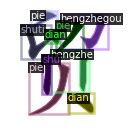

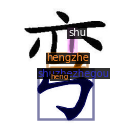

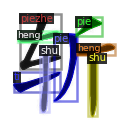

In [9]:
#笔画数据集
import random
for d in random.sample(wanzhengdataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=wanzheng_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])

Now, let's fine-tune a coco-pretrained R50-FPN Mask R-CNN model on the fruits_nuts dataset. It takes ~6 minutes to train 300 iterations on Colab's K80 GPU.


In [0]:
# from detectron2.engine import DefaultTrainer
# from detectron2.config import get_cfg
# import os

# cfg = get_cfg()
# cfg.merge_from_file("./detectron2_repo/configs/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
# cfg.DATASETS.TRAIN = ("fruits_nuts",)
# cfg.DATASETS.TEST = ()   # no metrics implemented for this dataset
# cfg.DATALOADER.NUM_WORKERS = 2
# cfg.MODEL.WEIGHTS = "detectron2://COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl"  # initialize from model zoo
# cfg.SOLVER.IMS_PER_BATCH = 2
# cfg.SOLVER.BASE_LR = 0.02
# cfg.SOLVER.MAX_ITER = 300    # 300 iterations seems good enough, but you can certainly train longer
# cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset
# cfg.MODEL.ROI_HEADS.NUM_CLASSES = 3  # 3 classes (data, fig, hazelnut)

# os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
# trainer = DefaultTrainer(cfg)
# trainer.resume_or_load(resume=False)
# trainer.train()

In [11]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
import os

cfg = get_cfg()

# Add PointRend-specific config
point_rend.add_pointrend_config(cfg)


# cfg.merge_from_file("./drive/My Drive/Colab Notebooks/detectron2_repo/configs/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
cfg.merge_from_file("detectron2_repo/projects/PointRend/configs/InstanceSegmentation/pointrend_rcnn_R_50_FPN_3x_coco.yaml")
cfg.DATASETS.TRAIN = ("wz",)
cfg.DATASETS.TEST = ()   # no metrics implemented for this dataset
cfg.DATALOADER.NUM_WORKERS = 2

# cfg.MODEL.WEIGHTS = "detectron2://COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl"  # initialize from model zoo
cfg.MODEL.WEIGHTS = "https://dl.fbaipublicfiles.com/detectron2/PointRend/InstanceSegmentation/pointrend_rcnn_R_50_FPN_3x_coco/164955410/model_final_3c3198.pkl"


cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.02
cfg.SOLVER.MAX_ITER = 800    # 300 iterations seems good enough, but you can certainly train longer
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 80 # 28 classes (heng,shu....)




#正式训练
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()


[03/30 04:17:07 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Now, we perform inference with the trained model on the fruits_nuts dataset. First, let's create a predictor using the model we just trained:



In [0]:
# Look at training curves in tensorboard:
%load_ext tensorboard
%tensorboard --logdir output

In [0]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set the testing threshold for this model
cfg.DATASETS.TEST = ("wz", )
predictor = DefaultPredictor(cfg)

Then, we randomly select several samples to visualize the prediction results.

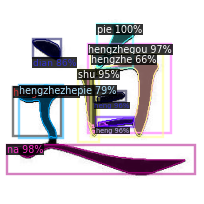

In [32]:
from detectron2.utils.visualizer import ColorMode

for d in random.sample(wanzhengdataset_dicts, 1):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=wanzheng_metadata, 
                   scale=0.8, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels用于实例化可视化的不同颜色模式  IMAGE_BW：与IMAGE相同，但将所有不带遮罩的区域转换为灰度。仅适用于按实例绘制蒙版预测
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(v.get_image()[:, :, ::-1])


    #如何输出单独的mask
    

In [0]:
# look at the outputs. See https://detectron2.readthedocs.io/tutorials/models.html#model-output-format for specification
outputs["instances"].pred_classes
outputs["instances"].pred_boxes
outputs["instances"]

In [33]:
wanzheng_metadata

Metadata(evaluator_type='coco', image_root='./drive/My Drive/pic566_28class/images', json_file='./drive/My Drive/pic566_28class/images566.json', name='wz', thing_classes=['piezhe', 'heng', 'hengzhewangou', 'pie', 'na', 'shuwangou', 'henggou', 'shugou', 'hengzhegou', 'hengzhezhezhegou', 'hengpie', 'shu', 'shuzhezhegou', 'dian', 'wangou', 'ti', 'shuti', 'shuzhe', 'wogou', 'hengzhe', 'xiegou', 'hengzhezhepie', 'hengzhewan', 'piedian', 'shuzhepie', 'hengxiegou', 'hengzheti', 'shuwan'], thing_dataset_id_to_contiguous_id={1: 0, 2: 1, 3: 2, 4: 3, 5: 4, 6: 5, 7: 6, 8: 7, 9: 8, 10: 9, 11: 10, 12: 11, 13: 12, 14: 13, 15: 14, 16: 15, 17: 16, 18: 17, 19: 18, 20: 19, 21: 20, 22: 21, 23: 22, 24: 23, 25: 24, 26: 25, 27: 26, 28: 27})

We can also evaluate its performance using AP metric implemented in COCO API. This gives an AP of ~70%. Not bad!

In [0]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("bhval", {}, "./drive/My Drive/dataset/val/val.json", "./drive/My Drive/dataset/val/images")

In [38]:
wanzheng_metadata = MetadataCatalog.get("bhval")
wanzhengdataset_dicts = DatasetCatalog.get("bhval")

[03/30 04:26:46 d2.data.datasets.coco]: Loaded 32 images in COCO format from ./drive/My Drive/dataset/val/val.json


In [40]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("bhval", cfg, False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, "bhval")
inference_on_dataset(trainer.model, val_loader, evaluator)
# another equivalent way is to use trainer.test

[03/30 04:27:25 d2.data.datasets.coco]: Loaded 32 images in COCO format from ./drive/My Drive/dataset/val/val.json
[03/30 04:27:25 d2.data.common]: Serializing 32 elements to byte tensors and concatenating them all ...
[03/30 04:27:25 d2.data.common]: Serialized dataset takes 0.07 MiB
[03/30 04:27:25 d2.evaluation.evaluator]: Start inference on 32 images
[03/30 04:27:26 d2.evaluation.evaluator]: Inference done 11/32. 0.0771 s / img. ETA=0:00:01
[03/30 04:27:28 d2.evaluation.evaluator]: Total inference time: 0:00:02.486242 (0.092083 s / img per device, on 1 devices)
[03/30 04:27:28 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:02 (0.083121 s / img per device, on 1 devices)
[03/30 04:27:28 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...


AssertionError: ignored

## Benchmark inference speed

In [41]:
import time
times = []
for i in range(20):
    start_time = time.time()
    outputs = predictor(im)
    delta = time.time() - start_time
    times.append(delta)
mean_delta = np.array(times).mean()
fps = 1 / mean_delta
print("Average(sec):{:.2f},fps:{:.2f}".format(mean_delta, fps))

Average(sec):0.08,fps:12.25
